In [1]:
import inferno
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [2]:
from sine_data import train_dataset, valid_dataset

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import insp

In [4]:
import visdom
vis = visdom.Visdom()

In [5]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [282]:
class InhCWRNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, inhibition='sigmoid', *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.input_inh = nn.Linear(input_dim, output_dim)
        
        #self.input_inh.bias.data.add_(1)
        
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        self.hidden_inh = nn.Linear(output_dim, output_dim, bias=False)
        
        self.f_mod = nn.Tanh()
        self.relu1 = nn.Hardtanh(min_val=0., max_val=1.)
        
        self.inhibition = inhibition
        
    def step(self, xi, h):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        inhs = self.input_inh(xi) + self.hidden_inh(h)
        
        module_acts = acts.view(-1, self.num_modules, module_size)
        module_inhs = inhs.view(-1, self.num_modules, module_size)
        
        if self.inhibition == 'relu':
            y = F.relu6(module_acts - module_inhs.sum(-1, keepdim=True))
            y = y.view(-1, self.output_dim)
            idx = (y == 0)
            hh = h.expand_as(y)
            y[idx] = hh[idx]
            return y, y
        
#         if self.inhibition == 'schmitt':
#             # simulate schmitt trigger? hard gating through trigger
#             # - module switches to on if v > thresh1
#             # - module switches to off if v < thresh2
#             yd = F.relu6(-module_inhs.sum(-1, keepdim=True).expand_as(module_acts))
#             yd = yd.view(-1, self.output_dim)
#             idx = (yd == 0)
#             hh = h.expand_as(yd)
#             y = acts
#             y[idx] = hh[idx]
            
#             if (module_inhs - h) > threshold_low:
#                 switch off (copy)
#             if (module_inhs - h) > threshold_high:
#                 switch on (update)
                
#             basically: if the inhibitor units are in a certain range, copy output
            
#             return y, y

        elif self.inhibition == 'exp':
            #module_inhs = F.tanh(module_inhs)
            m = module_inhs.mean(-1, keepdim=True)
            u = self.relu1(3/2 * m**4 + 1/8 * m**2)
            u = u.expand_as(module_acts).contiguous()
            u = u.view(-1, self.output_dim)
            
            y = (1 - u) * h + (u) * acts
            
            return y, y
        
        elif self.inhibition == 'sigmoid':
            gate = F.sigmoid(module_inhs.sum(-1, keepdim=True))
            gate = gate.expand_as(module_acts).contiguous()
            gate = gate.view(-1, self.output_dim)

            y = (1 - gate) * acts + gate * h        
            return y, y
        
        elif self.inhibition == 'baseline':
            return acts, acts
        
        raise ValueError('Unknown inhibition mode {}'.format(self.inhibition))

    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        for ti in range(t):
            xi = x[:, ti]
            yi, h = self.step(xi, h)            
            ys.append(yi)
        return torch.stack(ys, dim=1), h

In [219]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [283]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_modules=8, inhibition='sigmoid'):
        super().__init__()
        
        self.rnn = InhCWRNN(1, num_hidden, num_modules, inhibition=inhibition)
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn(x)
        
        vis.heatmap(l0[0].data.numpy(), win="foo")
        
        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [284]:
class Trainer(inferno.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

### exp inhibition

In [298]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optim=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
             module__inhibition='exp'
            )

In [299]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.3307        0.7852  0.9054
      2        0.8003        0.6743  1.3387
      3        0.6721        0.5339  0.8649
      4        0.5514        0.4559  1.0262
      5        0.4320        0.3759  0.9025
      6        0.3406        0.2705  1.1505
      7        0.2506        0.1901  0.7970
      8        0.1765        0.1217  0.9958
      9        0.1199        0.0743  0.8371
     10        0.0766        0.0557  0.9084
     11        0.0521        0.0536  0.8960
     12        0.0431        0.0453  0.9583
     13        0.0418        0.0410  0.8911
     14        0.0416        0.0384  0.8627
     15        0.0387        0.0310  0.9809
     16        0.0332        0.0202  0.8382
     17        0.0248        0.0165  0.9787
     18        0.0206        0.0150  1.0406
     19        0.0193        0.0130  0.9735
     20        0.0187        0.0137

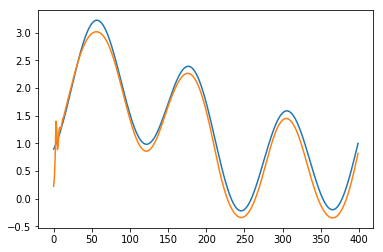

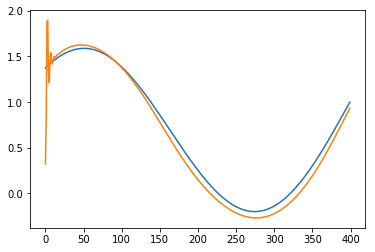

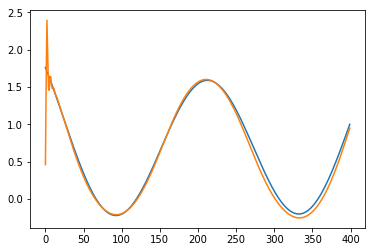

In [300]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

### sigmoid inhibition

In [212]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_sigmoid = Trainer(module=ReconModel,
             optim=torch.optim.RMSprop,
             lr=0.004,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
             module__inhibition='sigmoid'
            )

In [213]:
ef_sigmoid.fit(X_train[:, :-1], X_train[:, 1:])

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.9231        2.8883  0.9068
      2        2.5797        0.7302  0.7521
      3        0.7352        0.3079  0.8952
      4        0.2771        0.1830  0.6908
      5        0.1677        0.1194  0.7900
      6        0.1075        0.0849  0.9037
      7        0.0760        0.0690  0.8120
      8        0.0612        0.0606  0.7319
      9        0.0534        0.0547  0.7723
     10        0.0480        0.0497  0.8127
     11        0.0435        0.0455  0.8065
     12        0.0397        0.0418  0.7651
     13        0.0365        0.0386  0.7738
     14        0.0337        0.0357  0.8721
     15        0.0313        0.0332  0.7402
     16        0.0292        0.0310  0.8145
     17        0.0273        0.0289  0.7245
     18        0.0256        0.0271  0.8114
     19        0.0242        0.0255  0.8703
     20        0.0228        0.0240  0.6985
     21        0.0216        0.0

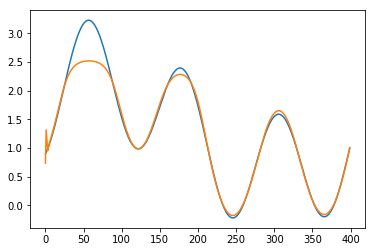

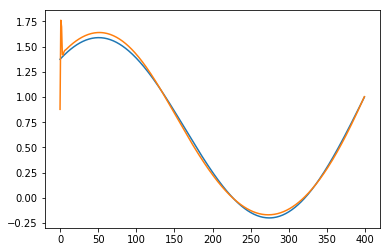

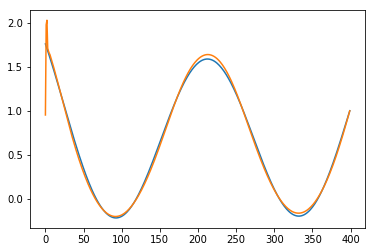

In [214]:
data = X_valid
pred = ef_sigmoid.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])